In [1]:
import pandas as pd 
import numpy as np 
import statsmodels.api as sm


# Q1

In [3]:
asset_returns = pd.read_excel('./final_exam_data.xlsx', sheet_name='Asset Returns').set_index('Date')
asset_betas = pd.read_excel('./final_exam_data.xlsx', sheet_name='Asset Betas')
factor_returns = pd.read_excel('./final_exam_data.xlsx', sheet_name='Factor Returns').set_index('Date')


In [4]:
def calc_cross_sectional_regression(mean_rets, betas, intercept=False):
    if intercept:
        betas = sm.add_constant(betas)
    model = sm.OLS(mean_rets, betas).fit()
    params = model.params.to_frame('Cross Sectional Regression')
    params.loc['R^2'] = model.rsquared
    params.loc['MAE'] = model.resid.abs().mean() 
    return params

In [5]:
def portfolio_metrics_basic(returns: pd.DataFrame, annualization_factor: float) -> pd.DataFrame: 
    '''
    Returns Annualized ER, Vol, SR, 
    '''
    
    returns_df = pd.DataFrame(index = returns.columns) 
    mu = returns.mean() * annualization_factor
    vol = returns.std() * np.sqrt(annualization_factor)
    sr = mu / vol

    
    returns_df['Annnualized Return'] = mu.values 
    returns_df['Annnualized Vol'] = vol.values 
    returns_df['Annnualized SR'] = sr.values
    
    return returns_df

In [6]:
asset_betas = asset_betas.set_index('Ticker')

#### Part 1

In [8]:
factor_risk_premium = []

for t in asset_returns.index:
    r_t = asset_returns.loc[t, :]  # Returns at time t
    beta_t = asset_betas           # Betas for corresponding assets
    # Perform OLS regression without intercept
    model = sm.OLS(r_t, beta_t, missing='drop').fit()
    lambda_t = model.params[0]  # Extract the estimated lambda_t
    factor_risk_premium.append(lambda_t)

factor_risk_premium = pd.Series(factor_risk_premium, index=asset_returns.index, name='Factor Risk Premium')
factor_risk_premium.tail(3)

/var/folders/nl/53zg25ln3zvfjy2zhc99g2yw0000gn/T/ipykernel_3810/446203375.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda_t = model.params[0]  # Extract the estimated lambda_t


Date
2024-11-06    0.022971
2024-11-07    0.001064
2024-11-08    0.001768
Name: Factor Risk Premium, dtype: float64

In [9]:
factor_risk_premium.mean() * 252, factor_risk_premium.mean() * np.sqrt(252)

(0.1754874142533425, 0.011054668008002758)

Annualized Mean = 0.175%, Annualized Vol = 0.0111

#### Part 2

<Axes: xlabel='Date'>

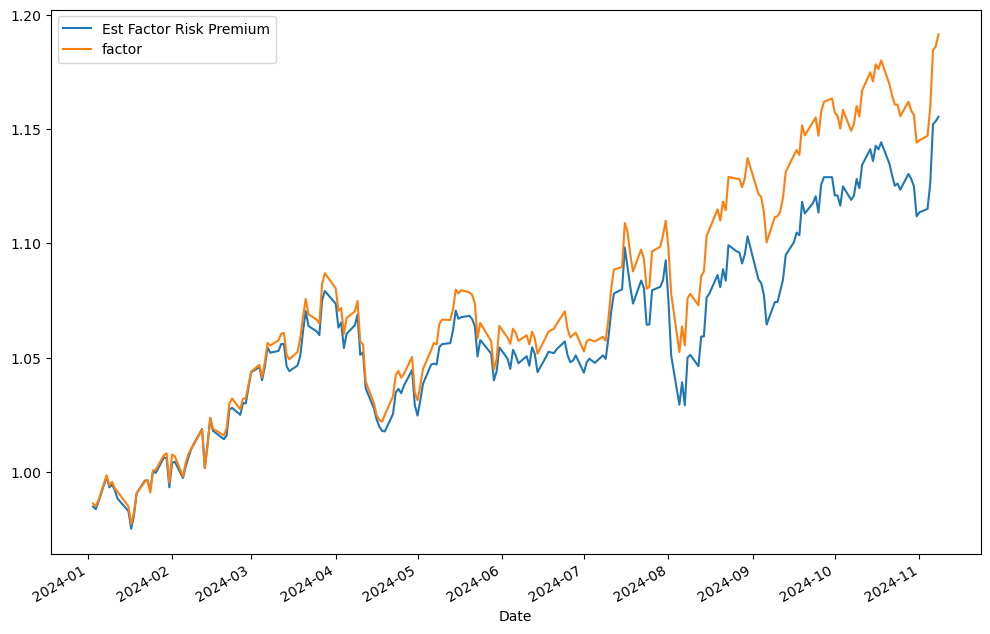

In [12]:
factor_risk_premium = factor_risk_premium.to_frame('Est Factor Risk Premium').reset_index()
factor_returns = factor_returns.reset_index()
combined_returns = pd.merge(factor_risk_premium, factor_returns, on = 'Date')[['Date', 'Est Factor Risk Premium', 'factor' ]]
combined_returns = combined_returns.set_index('Date')
(1 + combined_returns).cumprod().plot(figsize=(12,8)) # to plot cumulative returns -> use 1 + .cumprod()


In [13]:
combined_returns.corr().loc['Est Factor Risk Premium', 'factor']


0.9851319641635845

In [14]:
serial_correlations = {}

for column in ['Est Factor Risk Premium', 'factor']:
    series = combined_returns[column].dropna()
    lag1_autocorr = series.autocorr(lag=1)
    serial_correlations[column] = lag1_autocorr
serial_correlation_df = pd.DataFrame(serial_correlations, index=['Lag-1 Autocorrelation']).T
serial_correlation_df

,Lag-1 Autocorrelation
Est Factor Risk Premium,0.001564
factor,0.018438


- Serial Correlation of Factor Returns: Expected to be near zero for returns, under the Efficient Market Hypothesis where returns should follow a random walk (eg. martingale process) given that past returns do not predict future returns. 


- Serial Correlation of Factor Risk Premium: Positive autocorrelation over time due to technology and increasing volatility. 



#### Part 3

- The intercept term was excluded as in factor models, it assumes that all asset returns are explained by their exposure to risk factors. Therefore, if the model holds, then the intercept should thereotically be 0 as there should be no systematic returns unexplained by the factor. Including the intercept will instead distort the estimation by attributing part of the factor risk premium to the intercept.

- If the factor model does not fully explain the returns (e.g., missing risk factors or regime changes), the intercept term can capture the idiosyncracies in the data.

#### Part 4

In [19]:
calc_cross_sectional_regression(asset_returns.mean(), asset_betas, intercept=True)

,Cross Sectional Regression
const,0.000794
betas,0.000044
R^2,0.000309
MAE,0.000848


Based on the results, the factor model clearly performs poorly. There is a low R square and we should instead expect the factors in the model to explain all the expected returns in the portfolio. Otherwise, there means some factors remain unexplained as seen from the low R square of 0.000309. On the contrary, the model has a low MAE which is arisen from the average in residuals calculated in the model with a very low alpha (intercept that should ideally be 0)

#### Part 5

Since the actual factor returns refer to a EWP, there can be a bias in the weightings provided relative to the CAPM which aims to capture the true market risk premium. 
- eg. In the Fama French 3 factor model, HML which refers to the value premium from the factors aim to consider the growth and value stocks. In this case, value weighted portfolios from teh CAPM will give more weight to the larger cap stocks. However, smaller cap stocks often have higher average returns due to the size premium, leading to the EWP potentially over estimating the risk premiums.
- The estimated factor premiums from the equally-weighted portfolio will likely exhibit positive serial correlation due to the factor's tendency to overweight smaller stocks, which tend to have persistent performance patterns.

# Q2

In [24]:
fx_data  = pd.read_excel('./fx_rf_data.xlsx', sheet_name = 'exchange rates').set_index('date')
rf_data  = pd.read_excel('./fx_rf_data.xlsx', sheet_name = 'risk-free rates').set_index('date')
annualization_factor = 252
fx_data = fx_data.loc[:'2024-08-31']
rf_data = rf_data.loc[:'2024-08-31']
rf_data = rf_data / annualization_factor 
fx_data.isna().sum(), rf_data.isna().sum()

(JPY    0
 EUR    0
 GBP    0
 MXN    1
 CHF    0
 dtype: int64,
 USD    0
 JPY    0
 EUR    0
 GBP    0
 MXN    0
 CHF    0
 dtype: int64)

#### Part 1

In [26]:
fx_data.columns, rf_data.columns
aligned_rf_data = rf_data[fx_data.columns]
excess_returns = fx_data - aligned_rf_data
excess_returns.head(3)

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2008-01-01,0.008938,1.459031,1.986174,0.091532,0.882318
2008-01-02,0.009100,1.471357,1.980583,0.091322,0.893218
2008-01-03,0.009129,1.474844,1.970778,0.091572,0.900115


In [27]:
excess_returns.tail(3)

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2024-08-28,0.006907,1.111853,1.318899,0.050483,1.187354
2024-08-29,0.006888,1.107553,1.316600,0.049953,1.180156
2024-08-30,0.006832,1.104653,1.312502,0.050263,1.177056


#### Part 2

In [29]:
def performance_summary(return_data, quantile, annualization_factor):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization_factor)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization_factor))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['Min'] = return_data.idxmin()
    summary_stats['Max'] = return_data.idxmax()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    
    return summary_stats
performance_summary(excess_returns, 0.05, annualization_factor)[['Mean', 'Volatility', 'Skewness', 'Excess Kurtosis', 'Max Drawdown']]

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)


,Mean,Volatility,Skewness,Excess Kurtosis,Max Drawdown
JPY,2.402412,0.025707,0.341245,-0.247435,0.0
EUR,307.825281,2.169647,0.583025,-0.588456,0.0
GBP,365.005647,2.952675,0.716086,0.299467,0.0
MXN,16.099957,0.223641,0.443708,-1.005503,0.0
CHF,262.479938,1.127465,-0.267109,0.894672,0.0


In [30]:
excess_returns.corr()

,JPY,EUR,GBP,MXN,CHF
JPY,1.000000,0.683155,0.550700,0.595048,-0.097344
EUR,0.683155,1.000000,0.888446,0.871487,-0.144156
GBP,0.550700,0.888446,1.000000,0.899068,-0.155824
MXN,0.595048,0.871487,0.899068,1.000000,-0.163227
CHF,-0.097344,-0.144156,-0.155824,-0.163227,1.000000


#### Part 3

In [32]:
# has the most carry 
excess_returns_copy = excess_returns.loc[:'2017-12-31']
rf_data_copy = rf_data.loc[:'2017-12-31']
exchange_rates = list(excess_returns_copy.columns)
rets = pd.DataFrame(data=0, index=excess_returns_copy.index, columns=excess_returns_copy.columns)
for col in exchange_rates:
    rets[col] = (
        excess_returns_copy[col].shift(-1) # Gets spot_{t+1}
        - excess_returns_copy[col]         # Gets spot_{t}
        + rf_data[col]        # Risk free rate at time t -> t+1
        - rf_data["USD"]      # Local risk free rate at time t -> t+1
    )
average_carry = rets.mean()

max_carry_currency = average_carry.idxmax()
max_carry_value = average_carry.max()

print(f"The currency with the most carry is: {max_carry_currency} with an average carry of {max_carry_value:.4f}")

The currency with the most carry is: MXN with an average carry of 0.0002


Assuming UIP, the high carry of 0.0002 implies that the Peso offers a relatively high interest rate differential compared to the USD. This suggests low net returns, as future currency depreciation (or spot changes) would offset the carry advantage.

#### Part 4

In [35]:
def equal_weights(returns): 
    return pd.DataFrame(index = returns.columns, data = 1/len(returns.columns), columns = ['EWP Weights'])
weights = equal_weights(rets)
avg_currency_factor = rets.mean(axis = 1).to_frame('factor_z')
results = []

for col in exchange_rates: 
    x = rets[col] 
    y = avg_currency_factor
    model = sm.OLS(y, sm.add_constant(x),  missing='drop').fit()
    alpha = model.params['const'] * 252
    beta = model.params[col] 
    r_square = model.rsquared
    results.append({'Currency': col, 'Alpha': alpha, 'Beta': beta, 'R-Squared': r_square})

results_df = pd.DataFrame(results)
results_df

,Currency,Alpha,Beta,R-Squared
0,JPY,0.041077,12.157123,0.041581
1,EUR,0.003776,0.462567,0.776491
2,GBP,0.013276,0.366464,0.660271
3,MXN,-0.119867,2.871361,0.156317
4,CHF,-0.011316,0.401299,0.586599


#### Part 5

The ideal factor pricing model should be able to account for the expected risk premium of the currency trade, exhibiting a high r square value of near 1 and a low alpha since this should be accounted for by the betas. 
In this example, the currencies generally have low alphas but exhibit varying levels of R square values. 
For EUR, GBP, and CHF, the factor pricing model appears reasonable. The betas are moderate, alphas are close to zero, and R square indicate that the factor explains a good portion of their returns.

Therefore, the estimates do not conform to the ideal factor pricing model. 

#### Part 6 

A good diversified portfolio should have assets that exhibit low correlations with each other and have different risk profiles based on their expected returns and volatility. 

- From the data, CHF has a negative and low correlation with others (e.g., -0.097 with JPY, -0.144 with EUR), suggesting diversification potential. Conversely, EUR, GBP, and MXN have high correlations (e.g., 0.88 between EUR and GBP, 0.89 between GBP and MXN), reducing the benefits of diversification between these currencies.
- Therefore, the high correlations for the aforementioned currencies limits diversification benefits for portfolios which simply consists of EUR, GBP and MXN.
- As for their return profiles, GBP has the highest volatility followed by EUR and MXN and thus they can be diversified with the lower volatility currencies such as JPY and CHF.


In this case, MVO OOS performance may suffer due to the high correlation amongst EUR, GBP and MXN which have high correlation. In particular, GBP and EUR have very high expected returns compared to the others, which would lea to MVO to favour these currencies heavily. Therefore, this may provide instability to the covariance matrix. Furthermore, MVO assumes normality of returns and based on the skewness and kurtosis of the currency trades, these could lead to the poor risk adjusted performance for the MV optimized portfolio. Therefore, it is likely to perform poorly. 




#### Part 7

In [38]:
def tangency_weights(returns,dropna=True,scale_cov=1, name = 'Tangency'):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()
    tangency_weights_df = pd.DataFrame(weights, index=returns.columns, columns=[f'{name} Weights'])

    return tangency_weights_df
tan_weights = tangency_weights(rets)
tan_weights


,Tangency Weights
JPY,1.234173
EUR,0.005338
GBP,0.005684
MXN,-0.238620
CHF,-0.006576


In [39]:
tan_returns =  rets @ tan_weights.values
performance_summary(tan_weights, 0.05, annualization_factor)[['Mean', 'Volatility', 'Skewness', 'Excess Kurtosis', 'Max Drawdown']]

,Mean,Volatility,Skewness,Excess Kurtosis,Max Drawdown
Tangency Weights,50.4,9.324926,2.051864,4.446612,-0.243626


#### Part 8 

In [41]:
yen_trade = excess_returns.loc['2018':'2024-08-31']
rf_data_yen_trade = rf_data.loc['2018':'2024-08-31']
yen_carry_return = (
    yen_trade['JPY'].shift(-1)  # Spot_{t+1}
    - yen_trade['JPY']          # Spot_{t}
    + rf_data_yen_trade["USD"]  # USD risk-free rate (earning interest)
    - rf_data_yen_trade["JPY"]  # JPY risk-free rate (paying interest)
).dropna()
yen_carry_return.head(3), yen_carry_return.tail(3)


(date
 2018-01-01    0.000092
 2018-01-02    0.000041
 2018-01-03    0.000039
 dtype: float64,
 date
 2024-08-27    0.000173
 2024-08-28    0.000184
 2024-08-29    0.000147
 dtype: float64)

In [42]:
performance_summary(yen_carry_return.to_frame('short yen trade'), 0.05, annualization_factor)[['Mean', 'Volatility', 'Skewness', 'Excess Kurtosis', 'Max Drawdown', 'Min', 'Max']]

,Mean,Volatility,Skewness,Excess Kurtosis,Max Drawdown,Min,Max
short yen trade,0.022355,0.001403,0.363859,-0.142406,-0.000588,2020-03-09,2022-12-19
